In [4]:
import numpy as np
import pandas as pd
#from plotly.offline import iplot
#from plotly.graph_objs import *

#init_notebook_mode()
#import cufflinks as cf
#cf.go_offline()
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Gestion indicielle

## Gestion benchmarkée

La gestion indicelle est un type de gestion ou l'on doit battre un benchmark ou alors le repliquer le mieux possible. Si on prend un portefeuille $x$ et un benchmark $b$, on appelle l'erreur de réplication ( ou tracking error) l'écart suivant :

$$ \begin{array}{ccc}
e(t) &=& R_x(t)- R_b(t)\\
  &=&(x-b)^\top R(t)
\end{array}$$

On peut alors avoir la variance de la tracking error et la sur/sous performance moyenne :

$$ \begin{array}{ccc}
\mu(x|b) &=& (x-b)^\top \mu\\
\sigma^2(x|b) &=& (x-b)^\top \Sigma (x-b)
\end{array}$$

Ce sont exactement les memes formules que lorsque l'on regarde uniquement le portefeuille $x$ sauf que l'on regarde une difference de portefeuille.

On obtient également une mesure semblable au ratio de sharpe que l'on appelle le ratio d'information :

$$\theta(x|b) = \frac{\mu(x|b) }{\sigma(x|b) }  $$

Si on veut essayer de battre un indice on peut transformer le probleme de markowitz de la façon suiavnte :

\begin{eqnarray*}
x^{\star } &=&\arg \min \frac{1}{2}(x-b)^{\top }\Sigma (x-b) -\color{blue}{\phi \mu^\top (x-b)} \\
&\text{u.c.}&\left\{
\begin{array}{l}
x\in \mathcal{C} \\
\mathbf{1}^{\top }x=1 \\
x\geq \mathbf{0}
\end{array}
\right.  
\end{eqnarray*}

* Le paramètre $\phi$ est l'aversion à la tracking error. 
    *  ce paramètre sert à controler le risque de tracking error.

*  En gestion indicielle on peut egalement vouloir répliquer un indice. Par exemple repliquer le S&P500 mais avec une contrainte sur le nombre d'actif dans le portefeuille : **technique de l'echantillonage**



Plusieurs techniques : 

 * Enlever les actifs les plus petits en poids les uns après les autres tant que la contrainte de TE est respectée


 * Utilisation de la norme $L_1$ : cette norme permet de "sparsifier" le programme de markowitz :
   $$\begin{eqnarray*}
    x^{\star } &=&\arg \min \frac{1}{2}(x-b)^{\top }\Sigma (x-b) + \color{blue}{\lambda \sum_i |x_i| }\\
    &\text{u.c.}&\left\{
    \begin{array}{l}
    x\in \mathcal{C} \\
    \mathbf{1}^{\top }x=1 \\
    x\geq \mathbf{0}
    \end{array}
    \right.  
    \end{eqnarray*}$$
 

* Utilisation de contrainte entière (mixed integer quadratic programming, MIQP) :
    $$\begin{eqnarray*}
    x^{\star } &=&\arg \min \frac{1}{2}(x-b)^{\top }\Sigma (x-b) \\
    &\text{u.c.}&\left\{
    \begin{array}{l}
    x\in \mathcal{C} \\
    \mathbf{1}^{\top }x=1 \\
    x\geq \mathbf{0}\\
    \color{blue}{\sum_i \mathbf{1}\{ x_i>0\} \leq k}
    \end{array}
    \right.  
    \end{eqnarray*}$$

## Réplication d'indice à composantes cachées

Parfois on peut vouloir répliquer un indice ou un fonds dont on ne connait pas les expositions. Typiquement un indice représentatif de stratégie hedge funds.

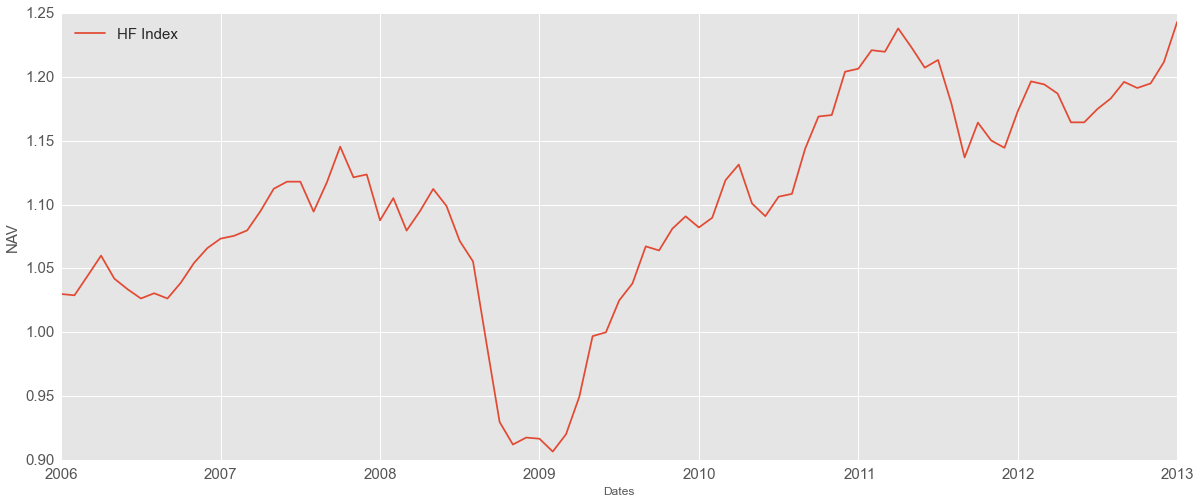

In [12]:
data = pd.read_csv("data-gb.csv",sep=",",index_col=0,  parse_dates=True,infer_datetime_format=True)
hf =  data["HF Index"] 
X = data.drop("HF Index",1)
(hf+1).cumprod().plot()
plt.ylabel('NAV',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15,loc='upper left')

On va supposer que le rendement de cet indice s'écrit :

$$R_I(t) = \sum_{i\in \mathcal{I}} \beta_i R_i(t) $$

Ou $\mathcal{I}$ est l'univers d'investissement à priori. Le problème est donc résolu par simple régression linéraire. 

**Exercice** : calculer la stratégie de réplication de l'indice et la tracking error. Comment améliorer ? 

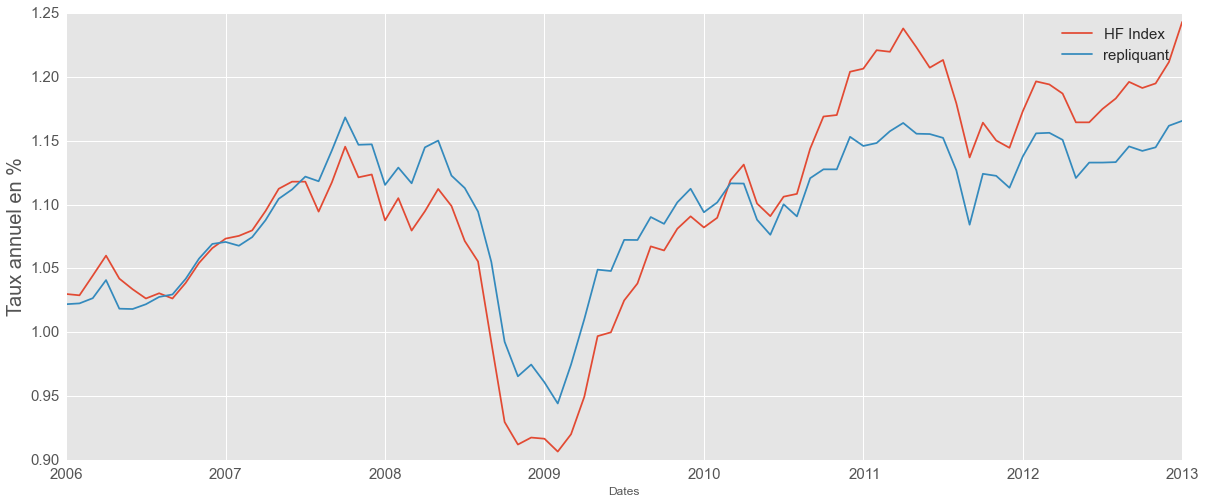

In [39]:
eonia = pd.read_csv("eonia.csv",sep=";",index_col=0, parse_dates=True,infer_datetime_format=True) 
eonia = eonia.loc[X.index]
#calcul du pas de temps
dt = pd.DataFrame(eonia.index[1:].values-eonia.index[:-1].values,columns={"dt"})
#calcul du rendement de eonia, vaut 0 en date 0
r_eonia =  np.array(eonia['EONIA Index'])*( np.hstack((dt["dt"].shift(-1).dt.days/365,1/365)))
r_eonia = np.nan_to_num(r_eonia)

 
track  = pd.DataFrame((hf+1).cumprod())
track["repliquant"] = (X.dot((np.linalg.inv(X.T.dot(X)).dot(X.T.dot(hf))  ))+r_eonia+1).cumprod()
track.plot()
plt.ylabel('Taux annuel en %',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)

# L'assurance de portefeuille

### Principes des fonds  garantis en capital

Notons $S_t$ et $B_t$ la valeur de l'actif sans risque (un zero coupon) et celle de l'actif risqué. Soit $V_t$ la valeur du portefeuille avec $V_0 = 1$.

Générallement une garantie en capital inclut un zero coupon : un instrument sans risque qui vaut 100% à la maturité. Sont prix est :

$$\mathrm{prix \, du \, zero \,coupon} = \exp(-\mathrm{maturité \, restante\, \times\mathrm{Taux}} )$$


$$ B(t,T) = \exp(-(T-t)R(t,T))$$

   * Grace au zéro coupon on va garantir un niveau de capital en T. 
   
   * Pour cela on achete  une quantité $x$ de zero coupon de maturité T : c'est le **plancher**
   
   * **Le restant est le coussin** $C_t$. Tant que le coussin est positif (V_t au dessus du plancher), la garantie peut être tenue
   
   $$C_t = V_t-xB_t$$

In [49]:
#Si taux = 3% et maturité 5 ans et garantie à 100%
B = np.exp(-0.03*5)
x = 1 
F = x*B
C = 1 -x*B
print "Le prix de la garantie (plancher) est de %s et le coussin initial de %s" % ("{0:.1%}".format(F) ,  "{0:.1%}".format(C) )

Le prix de la garantie (plancher) est de 86.1% et le coussin initial de 13.9%


Les frais de gestion ($fees$) introduisent une dérive entre les rendements nets et gross. Ils agissent comment un taux qui reste constant. Par exemple 1% par an. On obtient alors :

 $$\mathrm{prix\,de\,la\,garantie} = x \times  \exp(-(T-t)\left(R(t,T)-fees\right))$$

In [50]:
#Si taux = 3% , fees à 1%, maturité 5 ans et garantie à 100%
B = np.exp(-(0.03-0.01)*5)
x = 1 
C = 1 -x*B
print "Le prix de la garantie est de %s et le coussin initial de %s" % ("{0:.1%}".format(B*G) ,  "{0:.1%}".format(C) )

Le prix de la garantie est de 90.5% et le coussin initial de 9.5%


On peut aussi avoir une garantie implicit en utilisant un put. Par exemple si on achète une quantité $y$ d'actif risqué $S_t$ plus un put de strike K. On a :

$$ V_t = y(S_t + P_t^{\mathrm{put}}(K))$$
 
avec $y = \frac{V_0}{S_0+ P_0^{\mathrm{put}}(K)}$

A maturité $T$ on obtient :

$$
\begin{eqnarray*}
V_T &=&  \frac{V_0}{S_0+ P_0^{\mathrm{put}}(K)}(S_T + \max(K-S_T,0)) \\
\end{eqnarray*}$$

 * Si $S_T>K$ alors $V_T =   \frac{V_0}{S_0+ P_0^{\mathrm{put}}(K)}S_T> \frac{V_0}{S_0+ P_0^{\mathrm{put}}(K)}K$
 * Si $S_T \leq K$ alors $V_T =  \frac{V_0}{S_0+ P_0^{\mathrm{put}}(K)}K$

On en déduit que l'on a une garantie implicite :

$G =\frac{K}{S_0+ P_0^{\mathrm{put}}(K)}$

Maintenant on sait comment faire une garantie en capital, on va voir comment investir le reste :

* On peut investir dans des options (OBPI, produits structurés ex : zero coupon + call) 

* Directement dans l'actif risqué (CPPI)

## La méthode CPPI

L'exposition dans l'actif risqué est une fonction du coussin. C'est meme un multiplicateur du coussin et on a chaque date :

* Si $V_t>xB_t$ l'exposition dans l'actif risqué est donnée par $mC_t = m(V_t-xB_t)$

    *  Un multiple fort correspond à un levier plus fort, mais le fonds
est alors exposé à une monétarisation plus rapide en cas de baisse des marchés


*  Si $V_t<xB_t$ le portefeuille est entierement investi en zero coupon car $C_t = 0$

On supposera que x = 1 et que donc on veut garantir 100% du capital.

0n suppose également que l'actif risqué suis un modele de Black et Scholes : 

$$\frac{\mathrm{d}S_t}{S_t}  = \mu\mathrm{d}t + \sigma\mathrm{d}W_t$$

Si on reprend les notations precédantes on sait que le portefeuille est investi in fine dans un zero coupon pour la garantie en capital et a une exposiiton de $mC_t$ dans l'actif risqué.

La dynamique autofinancée de ce portefeuille s'écrit :

$$\mathrm{d}V_t = (V_t-mC_t) \frac{\mathrm{d}B_t}{B_t} + mC_t\frac{\mathrm{d}S_t}{S_t} = V_t r\mathrm{d}t + mC_t\left(\frac{\mathrm{d}S_t}{S_t}-r\mathrm{d}t \right) $$

 
et par définition on a aussi la valeur du portefeuille qui doit étre égale au zero coupon plus le coussin et donc :

$$ \mathrm{d}V_t = \mathrm{d}B_t + \mathrm{d}C_t = B_tr\mathrm{d}t+\mathrm{d}C_t$$



En remplançant $\mathrm{d}V_t$ par sa valeur et en utilisant le fait que $V_t r\mathrm{d}t = (C_t+B_t )r\mathrm{d}t$ on obtient :

$$\frac{\mathrm{d}C_t}{C_t} = (r+m(\mu-r))\mathrm{d}t+m\sigma \mathrm{d}W_t $$



Le coussin est donc une stratégie de levier $m$ dans l'actif risqué. Il reste positif si son rendement est supérieur à -100%. Soit :

$$\frac{\mathrm{d}C_t}{C_t} = m\frac{\mathrm{d}S_t}{S_t}>-1$$

Si on suppose que le risque maximum de l'actif risque est -20% il faudra alors $m<5$.




On obtient facilement une expression pour la valeur du coussin :

$$ C_T = C_0\exp\left(rT+m(\mu-r)T+m\sigma W_T -\frac{m^2\sigma^2T}{2} \right)$$



La valeur de $C_t$ est donc toujours positive et on peut en déduire que :

$$V_T= B_T + C_T\geq B_T = 1$$

La valeur du portefeuille à maturité est supérieure ou égale à la garantie.

La valeur du coussin ne dépend pas de la trajectoire. En effet nous avons :
$$ \sigma W_T = \ln\frac{S_T}{S_0}-(\mu-\frac{1}{2}\sigma^2) T $$

et donc :

$$ 
\begin{eqnarray*}
C_T &=& C_0\exp\left(rT+m(\mu-r)T+m\sigma W_T -\frac{m^2\sigma^2T}{2} \right)\\
   &=& C_0\left(\frac{S_T}{S_0}\right)^m\exp\left((1-m)rT+\frac{(m-m^2)\sigma^2T}{2} \right)
\end{eqnarray*}
$$

**Exercice :** Donner la sensibilité de l'exposition à une variation de marché, de taux et de volatilité. Pourquoi est ce une stratégie trend following ? Faire une simulation d'un CPPI sur un actif.

On peut trouver un multiplicateur optimal en maximisant l'esperance de taux de croissance du coussin. Cette approche est la meme que si l'on maximise l'utilité log :

$$ m^\star = \mathrm{arg}\max \mathbb{E}\left(\ln\frac{C_T}{C_0}  \right)$$

Le faire en exercice et appliquer dans les simulations.